In [1]:
import os
import subprocess
import json
import dicom2nifti
import nibabel as nib
import numpy as np
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

os.sep = "/"
volume, pseudonym = "D:" + os.sep + "nsclc", os.sep + "tmp" + os.sep + "NSCLC"


input_suffix = os.sep + "tcia" + os.sep + "manifest-1710086948977" + os.sep + "NSCLC-Radiomics" + os.sep
input_stream = pseudonym + input_suffix
real_input = volume + input_suffix

output_suffix = os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset004_Corrected" + os.sep
output_ct_suffix = output_suffix + "imagesTr"
output_ct = pseudonym + output_ct_suffix
real_output_ct = volume + output_ct_suffix

output_labels_suffix = output_suffix + os.sep + "labelsTr"
output_labels =         pseudonym   + output_labels_suffix
real_output_labels =    volume      + output_labels_suffix

#get folders in real_input



def run_docker_command(input_path, name, format="nifti"):
    # Corrected Docker command with volume mapping and paths adjusted for Windows
    command = [
        "docker", "run", 
        "-v", f"{volume}:{pseudonym}", 
        "qiicr/dcmqi", 
        "segimage2itkimage", 
        "-t", format,
        "-p", name,
        "--outputDirectory", output_labels, 
        "--inputDICOM", input_path
    ]

    # Run the command
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Check if the command was successful
    if result.returncode == 0:

        logging.info("Docker command executed successfully!")
        logging.info(f"Output:\n{result.stdout}")
    else:
        logging.error("Error running Docker command:")
        logging.error(f"Error output:\n{result.stderr}")

#check if input folder exists if not abort
if not os.path.exists(real_input):
    logging.error(f"input folder {real_input} does not exist")
    exit(1)

#check if output folders exist, if not create them
if not os.path.exists(real_output_ct):
    logging.warning(f"creating {real_output_ct}")
    os.makedirs(real_output_ct)
if not os.path.exists(real_output_labels):
    logging.warning(f"creating {real_output_labels}")
    os.makedirs(real_output_labels)



folders = os.listdir(real_input)


for folder in folders:
    #get folders in folder
    work_path = real_input + "/" + folder
    subfolder_patient = os.listdir(work_path)[0]
    work_path = work_path + "/" + subfolder_patient
    subfolders_cases = os.listdir(work_path)
    # in this list there is a folder called Segmentation, we want to put it at the end
    segmentation = [x for x in subfolders_cases if "Segmentation" in x]
    # remove it from the list and add it at the end
    subfolders_cases = [x for x in subfolders_cases if x not in segmentation]
    subfolders_cases.append(segmentation[0])
    
    logging.debug(f"order of subfolders: {subfolders_cases}")


    
    skipped_segmentation = False
    affine_matrix = None
    for subfolder_case in subfolders_cases:
        #check if already in output folder 

        if "Segmentation" in subfolder_case:
            input_command = input_stream + "/" + folder + "/" + subfolder_patient + "/" + subfolder_case + "/1-1.dcm"
            # check if already in output folder
            if os.path.exists(real_output_labels + "/" + folder + ".nii.gz"):
                logging.info(f"skipping {folder} as Segmentation already exists")
                skipped_segmentation = True
            elif skipped_segmentation is True:
                
                logging.warning(f"skipping {folder} as dicom conversion failed")
            else:
                logging.info(f"converting {folder} Segmentation to nifti")
                run_docker_command(input_command, folder)
        else:
            # check if already in output folder
            if os.path.exists(real_output_ct + "/" + folder + "_0000.nii.gz"):
                logging.info(f"skipping {folder} as CT already exists")
                
            else:
                try:
                    
                    logging.info(f"converting {folder} CT to nifti")
                    dicom2nifti.dicom_series_to_nifti(work_path + "/" + subfolder_case, real_output_ct+"/"+folder+"_0000.nii.gz")
                    logging.debug(f"CT converted to nifti")
                    # try loading the nifti file to see if it worked
                    temp = nib.load(real_output_ct + "/" + folder + "_0000.nii.gz")
                    logging.debug(f"CT loaded successfully")
                    #get affine matrix
                    affine_matrix_ct = temp.affine.copy()
                    logging.debug(f"affine matrix loaded successfully")
                    #get fdata
                    data = temp.get_fdata()
                    logging.debug(f"CT data loaded successfully")

                except:
                    # check if file was created and delete it
                    if os.path.exists(real_output_ct + "/" + folder + "_0000.nii.gz"):
                        logging.warning(f"deleting {real_output_ct + '/' + folder + '_0000.nii.gz'}")
                        os.remove(real_output_ct + "/" + folder + "_0000.nii.gz")
                        logging.warning(f"deleted {real_output_ct + '/' + folder + '_0000.nii.gz'}")
                    logging.warning(f"skipping {folder} as CT could not be converted or loaded")
                    skipped_segmentation = True
                    break

    if skipped_segmentation:
        continue
    meta_data_path = real_output_labels + "/" + folder + "-meta.json"
    with open(meta_data_path, "r") as file:
        meta_data = json.load(file)
    for segmentation in meta_data['segmentAttributes']:
        if 'Neoplasm' in segmentation[0]['SegmentLabel']:
            tumor_id = segmentation[0]['labelID']
    # elements are of name folder-x.nii.gz, find all of them
    files = os.listdir(real_output_labels)
    for file in files:
        if folder in file:
            if f"{tumor_id}.nii.gz" in file:
                #rename it as folder.nii.gz
                curr_label = real_output_labels + "/" + file
                new_label = real_output_labels + "/" + folder + ".nii.gz"
                os.rename(curr_label, new_label)

                seg = nib.load(new_label)
                data = seg.get_fdata()
                data[data == tumor_id] = 1
                data = np.flip(data, axis=1) # <------ !!! WARNING: this is a contingent solution based on how the DICOM SEG in the dataset and dcmqi work, this modification allows to see in the correct orientation both the npz files of nnunet and 3d slicer representation! if for you it works like shit, probably you need to comment this line
                new_seg = nib.Nifti1Image(data, affine_matrix_ct, seg.header) # use the affine matrix from the CT in order to have the same space
                nib.save(new_seg, new_label)
                
            else: #delete it
                #print(f"deleting {real_output_labels + '/' + file}")
                logging.info(f"deleting {real_output_labels + '/' + file}")
                os.remove(real_output_labels + "/" + file)


2024-03-10 22:42:40,885 - WARNING - creating D:/nsclc/data/nnUNet_raw/Dataset004_Corrected/imagesTr
2024-03-10 22:42:40,894 - WARNING - creating D:/nsclc/data/nnUNet_raw/Dataset004_Corrected//labelsTr
2024-03-10 22:42:40,901 - DEBUG - order of subfolders: ['0.000000-NA-82046', '300.000000-Segmentation-9.554']
2024-03-10 22:42:40,902 - INFO - converting LUNG1-001 CT to nifti
2024-03-10 22:42:41,169 - INFO - WARNING: Assuming generic vendor conversion (ANATOMICAL)
2024-03-10 22:42:41,187 - INFO - Reading and sorting dicom files
2024-03-10 22:42:41,624 - INFO - Saving nifti to disk D:/nsclc/data/nnUNet_raw/Dataset004_Corrected/imagesTr/LUNG1-001_0000.nii.gz
2024-03-10 22:42:43,334 - DEBUG - CT converted to nifti
2024-03-10 22:42:43,335 - DEBUG - CT loaded successfully
2024-03-10 22:42:43,336 - DEBUG - affine matrix loaded successfully
2024-03-10 22:42:43,701 - DEBUG - CT data loaded successfully
2024-03-10 22:42:43,702 - INFO - converting LUNG1-001 Segmentation to nifti
2024-03-10 22:42:4

In [ ]:
# correctness check, for all the files in both folders, try loading, get fdata and check they have same dimensions and orientation
import os
import subprocess
import json
import dicom2nifti
import nibabel as nib
import numpy as np
import logging
from tqdm import tqdm
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

os.sep = "/"
volume, pseudonym = "D:" + os.sep + "nsclc", os.sep + "tmp" + os.sep + "NSCLC"


input_suffix = os.sep + "tcia" + os.sep + "manifest-1710086948977" + os.sep + "NSCLC-Radiomics" + os.sep
input_stream = pseudonym + input_suffix
real_input = volume + input_suffix

output_suffix = os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset004_Corrected" + os.sep
output_ct_suffix = output_suffix + "imagesTr"
output_ct = pseudonym + output_ct_suffix
real_output_ct = volume + output_ct_suffix

output_labels_suffix = output_suffix + os.sep + "labelsTr"
output_labels =         pseudonym   + output_labels_suffix
real_output_labels =    volume      + output_labels_suffix


ct_files = os.listdir(real_output_ct)

label_files = os.listdir(real_output_labels)

ct_files.sort()
label_files.sort()

mistakes_were_made = False
print("Checking for errors in input and output folders...")
#for n, file in enumerate(ct_files): <- make tqdm below
for n in tqdm(range(len(ct_files))):
    file = ct_files[n]

    # Check if file is in Segmentation folder, ct has name x_0000.nii.gz, label has name x.nii.gz
    #remove _0000.nii.gz
    file_name = file.split("_0000")[0]
    label_file = file_name + ".nii.gz"

    if label_file not in label_files:
        logging.warning(f"File {file} found in CT folder but not in Segmentation folder.")
        continue

    # Attempt to load CT file
    try:
        ct_path = os.path.join(real_output_ct, file)
        ct = nib.load(ct_path)
        ct_img = ct.get_fdata()
    except Exception as e:
        logging.error(f"Error loading CT file {file}: {str(e)}")
        #remove file from folder
        os.remove(ct_path)
        logging.warning(f"deleting {ct_path}")
        # remove segmentation file as well
        label_path = os.path.join(real_output_labels, label_file)
        os.remove(label_path)
        logging.warning(f"deleting {label_path}")
        mistakes_were_made = True
        continue  # Skip further checks if CT file couldn't be loaded

    # Attempt to load label file
    try:
        label_path = os.path.join(real_output_labels, label_file)
        label = nib.load(label_path)
    except Exception as e:
        logging.error(f"Error loading label file {file}: {str(e)}")
        mistakes_were_made = True
        continue  # Skip further checks if label file couldn't be loaded

    # Check if shapes are different
    if ct.shape != label.shape:
        logging.warning(f"File {file} has different shapes in CT and Segmentation folders.")
        mistakes_were_made = True
        #show orientation
    
    # Check if affine matrices are different
    if not np.allclose(ct.affine, label.affine):
        logging.warning(f"File {file} has different affine matrices in CT and Segmentation folders.")
        mistakes_were_made = True
        
        
        


if mistakes_were_made:
    logging.error("Errors were found in input and output folders. Please check the logs for details.")
    logging.error("Erroneous files may have been deleted. Run the script again to reprocess the data. Only the erroneous files will be reprocessed.")
else:
    logging.info("God is in his heaven, all is right with the world.")


Checking for errors in input and output folders...


100%|██████████| 401/401 [02:42<00:00,  2.47it/s]
2024-03-10 21:57:03,741 - INFO - God is in his heaven, all is right with the world.


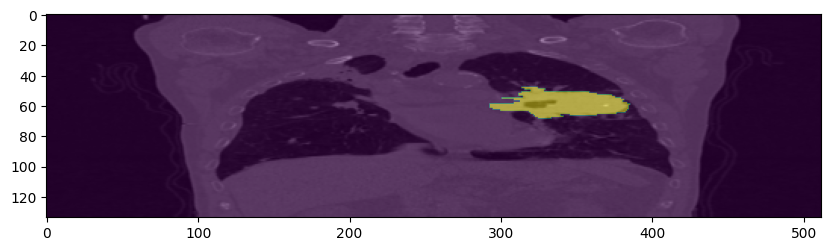

In [ ]:
import matplotlib.pyplot as plt
ct = nib.load(real_output_ct + "/LUNG1-088_0000.nii.gz")
seg = nib.load(real_output_labels + "/LUNG1-088.nii.gz")
ct_slice = ct.get_fdata()[:,:,87].copy()
seg_slice = seg.get_fdata()[:,:,87].copy()

#rotate both 90 degrees counter clockwise
ct_slice = np.rot90(ct_slice)
seg_slice = np.rot90(seg_slice)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(ct_slice, cmap="gray")
ax.imshow(seg_slice, alpha=0.5)


plt.show()

